# Creating surface forcing

In [1]:
from roms_tools import Grid, SurfaceForcing

As always, the first step is to create our grid. Let's start with a coarse-resolution grid with a horizontal resolution of 2000km/100 = 20km.

In [2]:
grid = Grid(
    nx=100,
    ny=100,
    size_x=2000,
    size_y=2000,
    center_lon=-18,
    center_lat=33,
    rot=-20,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

Next, we specify the temporal range that we want to make the surface forcing for.

In [3]:
from datetime import datetime

In [4]:
start_time = datetime(2012, 1, 15)
end_time = datetime(2012, 2, 5)

`ROMS-Tools` can create two types of surface forcing:

* physical surface forcing like 10m wind, shortwave radiation, and air temperature at 2m
* biogeochemical (BGC) surface forcing like atmospheric pCO2

Unlike initial conditions data, ROMS can read multiple surface forcing files, so we create these two types separately in the following sections.

## Physical surface forcing

In this section, we use ERA5 data to construct the physical surface forcing. There are two ways to access the data:

- **Stream directly from the cloud** (no download required)
- **Use locally pre-downloaded files** by specifying the path

**Streaming** is convenient: there's no need to download data in advance.  
**Local files**, on the other hand, can reduce initialization time if you already have the data available.

Let's explore both options with these keyword arguments:

In [5]:
surface_forcing_kwargs = {
    "grid": grid,
    "start_time": start_time,
    "end_time": end_time,
    "type": "physics",
    "model_reference_date": datetime(2000, 1, 1), # this is the default
}

### Streaming Cloud-based ERA5 Data

Let's begin by exploring the streaming approach. This method uses [ARCO (Analysis-Ready, Cloud Optimized) ERA5 data](https://github.com/google-research/arco-era5/?tab=readme-ov-file#025-pressure-and-surface-level-data) from the public Google Cloud Storage bucket:
```bash
gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3
```
To activate the streaming approach in ROMS-Tools, simply omit the path in the `source` or explicitly provide the cloud storage URL:

* `source = {"name": "ERA5"}`
* `source = {"name": "ERA5", "path": "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"}`

<div class="alert alert-info">

Note

Streaming **requires** `use_dask = True` since the underlying data format is Zarr, which supports lazy loading and chunked access via Dask. [Here](https://roms-tools.readthedocs.io/en/latest/using_dask.html) you can learn more about using `Dask` with `ROMS-Tools`.

</div>

In [6]:
%%time

surface_forcing = SurfaceForcing(
    **surface_forcing_kwargs,
    source={"name": "ERA5"},
    use_dask=True,
)

INFO - No path specified for ERA5 source; defaulting to ARCO ERA5 dataset on Google Cloud.
INFO - Data will be interpolated onto fine grid.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 3min 26s, sys: 8.04 s, total: 3min 34s
Wall time: 1min 44s


Instantiating the surface forcing took over 1.5 minutes, even though no computations have been performed yet due to Dask’s lazy evaluation. **This delay results from streaming data from the cloud.** 

The surface forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property. Indeed, all variables are Dask arrays representing lazy-loaded data.

In [7]:
surface_forcing.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

`ROMS-Tools` has found 505 time stamps within our specified time range. Let's double-check that `ROMS-Tools` has selected the correct times.

In [8]:
surface_forcing.ds.time

<xarray.DataArray 'time' (time: 505)> Size: 4kB
array([4397.      , 4397.041667, 4397.083333, ..., 4417.916667, 4417.958333,
       4418.      ], shape=(505,))
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Attributes:
    long_name:  relative time: days since 2000-01-01 00:00:00
    units:      days

<div class="alert alert-info">

Note

The `time` variable shows relative time, i.e., days since the model reference date (here set to January 1, 2000 by default). The `abs_time` coordinate shows the absolute time. The ERA5 data provided to `ROMS-Tools` has hourly frequency; this temporal frequency is inherited by `surface_forcing`.
    
</div>

To visualize any of the surface forcing fields, we can use the `.plot` method.

[########################################] | 100% Completed | 103.71 ms


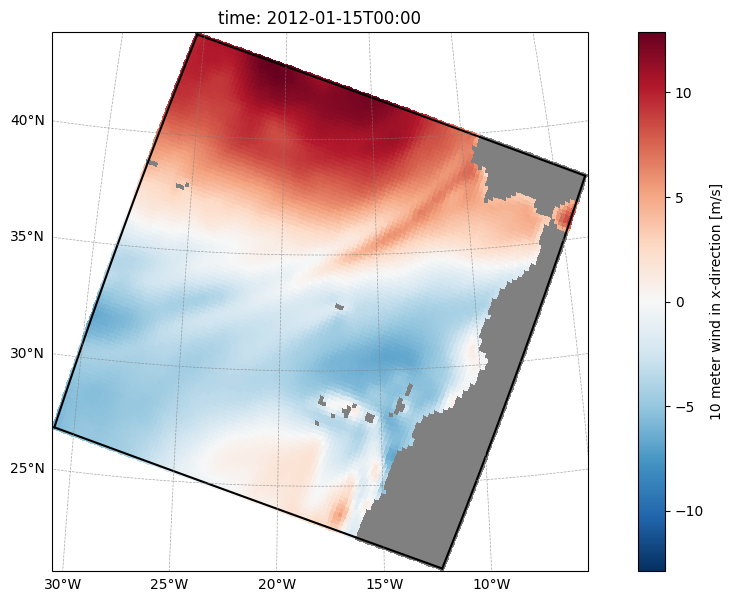

In [9]:
surface_forcing.plot("uwnd", time=0)

[########################################] | 100% Completed | 607.52 ms


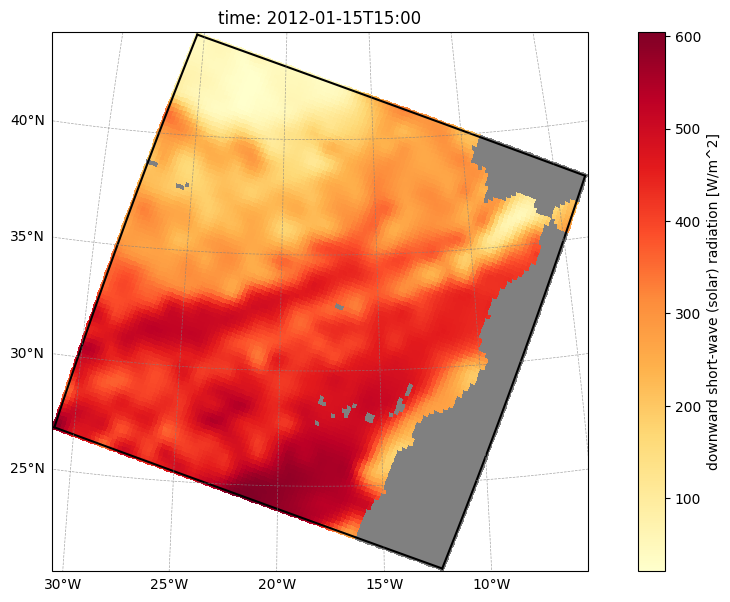

In [10]:
surface_forcing.plot("swrad", time=15)

### Using Local Pre-Downloaded ERA5 Data
Next, let's make the same surface forcing but using pre-downloaded ERA5 data sitting at the following location.

In [11]:
path = "/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/ERA5*.nc"

You can also download your own ERA5 data, which must span the desired ROMS domain and temporal range. For more details, please refer to [this page](https://roms-tools.readthedocs.io/en/latest/datasets.html).

In [12]:
%%time

surface_forcing_from_local_data = SurfaceForcing(
    **surface_forcing_kwargs,
    source={"name": "ERA5", "path": path},
    use_dask=True,
)

INFO - Data will be interpolated onto fine grid.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 1min 36s, sys: 527 ms, total: 1min 36s
Wall time: 12 s


Instantiating the surface forcing was much faster this time (just over 10 seconds) because it did not require streaming data.

## 

In [13]:
surface_forcing_from_local_data.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

### Shortwave radiation correction

Global data products like ERA5 are known to have biases in radiation, largely due to uncertainties in cloud-radiative feedbacks. To address these biases, `ROMS-Tools` includes a correction mechanism. When the `correct_radiation` parameter is set to `True` (which is the default), a multiplicative correction factor is applied to the ERA5 shortwave radiation data. These correction factors are pre-computed based on the difference between ERA5 climatology and the COREv2 climatology.

As a result, the `surface_forcing` dataset we generated above includes a shortwave radiation correction, since the default setting for `correct_radiation` is `True`. 
In the following, we create surface forcing where no correction is applied. While this approach is possible, it is **not recommended** due to the known biases in the ERA5 radiation data.

In [14]:
%%time

uncorrected_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    correct_radiation=False,  # default is True
    use_dask=True,
)

INFO - Data will be interpolated onto fine grid.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 53.8 s, sys: 77.6 ms, total: 53.9 s
Wall time: 2.29 s


In [15]:
uncorrected_surface_forcing.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     False
    wind_dropoff:          False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

Here is a plot of the downward short-wave radiation, as before, but now in its uncorrected version.

[########################################] | 100% Completed | 101.93 ms


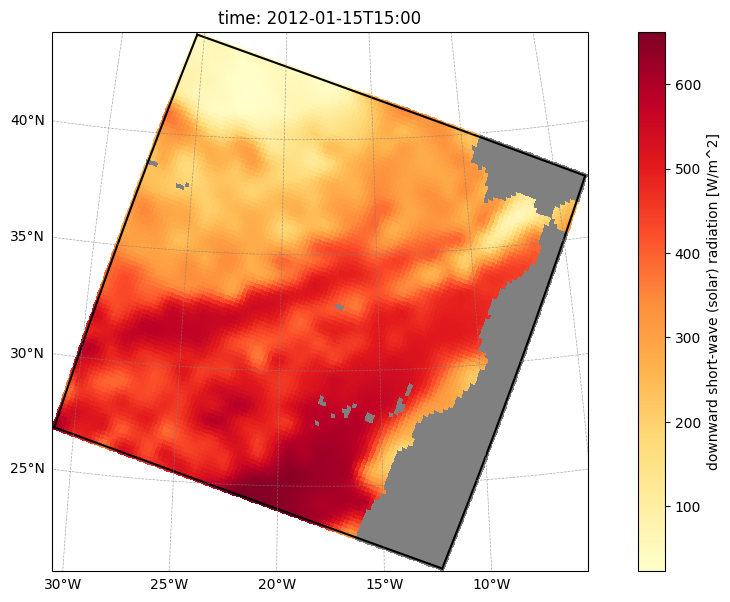

In [16]:
uncorrected_surface_forcing.plot("swrad", time=15)

Let's plot the differences in corrected and uncorrected short-wave radiation.

In [17]:
from roms_tools.plot import plot

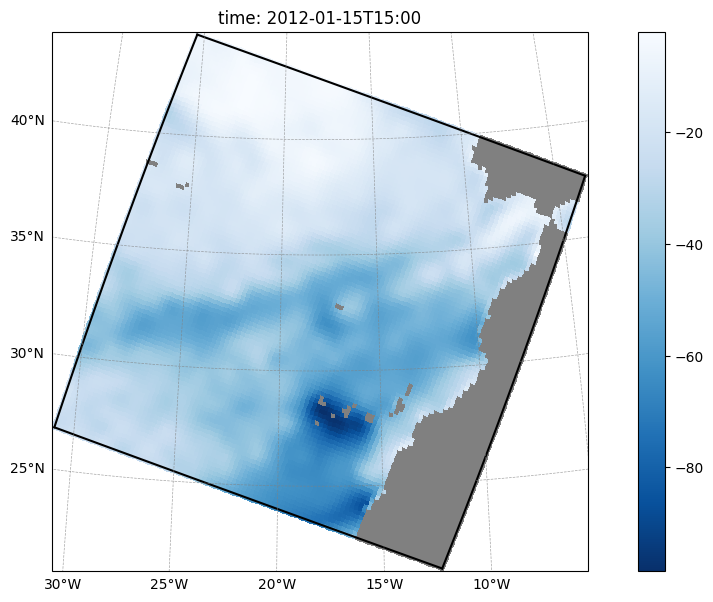

In [18]:
plot(
    (surface_forcing.ds["swrad"] - uncorrected_surface_forcing.ds["swrad"]).isel(
        time=15
    ),
    grid_ds=grid.ds,
    cmap_name="Blues_r",
)

### Wind Correction Near the Coast

ERA5’s 1/4° resolution is too coarse to capture realistic coastal winds, particularly the wind drop-off near the coast. This drop-off is caused by coastal orography and differences between marine and terrestrial surface layers. It plays a crucial dynamical role in coastal upwelling systems, where the wind stress curl in the drop-off zone significantly influences Ekman pumping and biogeochemical reaction rates.

To address this limitation, `ROMS-Tools` can apply an exponential reduction in wind magnitude near the coastline. This correction uses an e-folding scale of 12.5 km, smoothly transitioning from full offshore wind strength to a 40% reduction at the shore. The behavior is controlled by the `wind_dropoff` parameter, which is set to `False` by default.

In [19]:
surface_forcing_with_wind_drop_off = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    wind_dropoff=True,
    use_dask=True,
)

INFO - Data will be interpolated onto fine grid.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


In [20]:
surface_forcing_with_wind_drop_off.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    wind_dropoff:          True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

Here is a plot of the zonal wind, as before, but now with reduced amplitude near the coasts.

[########################################] | 100% Completed | 101.87 ms


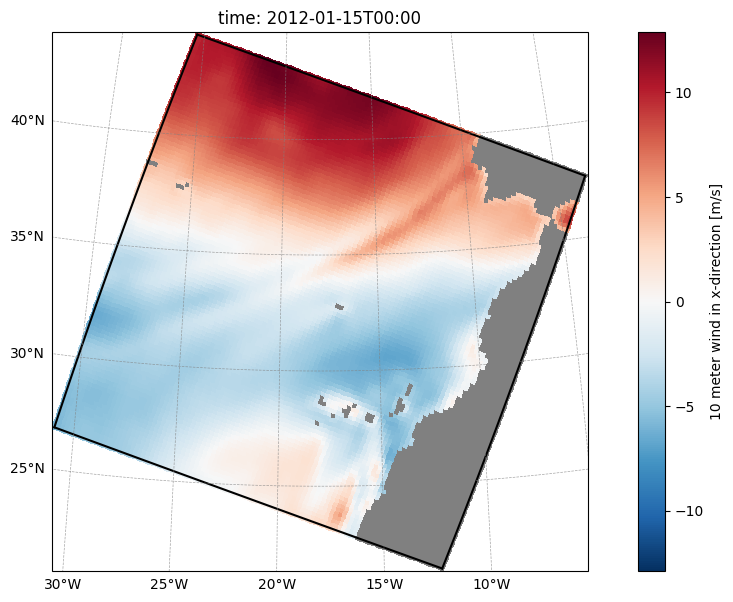

In [21]:
surface_forcing_with_wind_drop_off.plot("uwnd", time=0)

Here is the difference between the uncorrected and corrected wind.

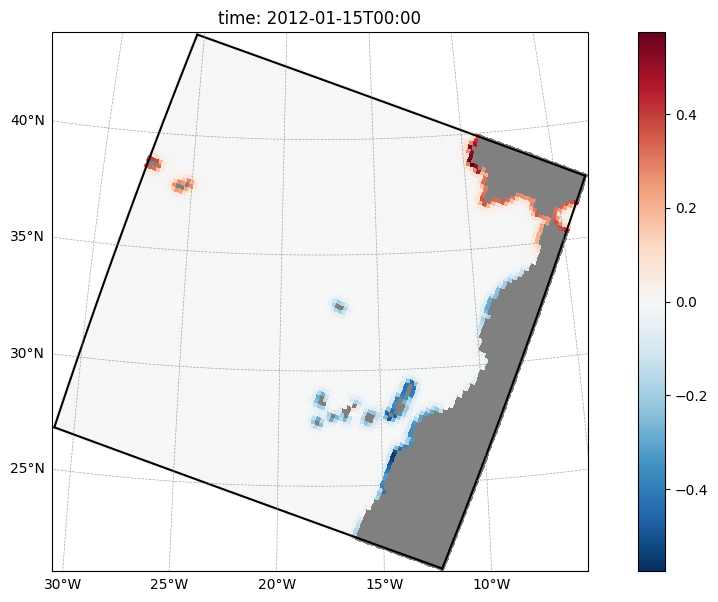

In [22]:
plot(
    (surface_forcing.ds["uwnd"] - surface_forcing_with_wind_drop_off.ds["uwnd"]).isel(
        time=0
    ),
    grid_ds=grid.ds,
    cmap_name="RdBu_r",
)

The plot above highlights differences concentrated in near-coastal areas. Comparing the sign of the difference plot with the original wind field shows that positive wind values have been reduced and negative values enhanced, indicating a consistent reduction in wind amplitude near the coast.

### Fine vs. coarse grid

`ROMS-Tools` provides the option to interpolate surface forcing fields onto a "coarse grid," which has a resolution that is a factor of 2 coarser than the original "fine grid." Interpolating onto the coarse grid is useful when the ROMS grid resolution is at least twice as fine as that of the raw data product (e.g., ERA5). In such cases, interpolating onto the fine grid would not provide additional information compared to the coarse grid, making the coarse grid a more efficient choice and saving computational resources.

To control the choice between fine and coarse grids, `ROMS-Tools` provides the `coarse_grid_mode` argument, which accepts the following options:

- "auto" (default): Automatically selects the appropriate grid based on the comparison of the source and target spatial resolutions.
- "always": Always interpolate onto the coarse grid.
- "never": Always interpolate onto the fine grid, bypassing the coarse grid.

`ROMS-Tools` generates an informational message to indicate whether the fine or coarse grid is being used. 

The surface forcings we have generated so far have used `coarse_grid_mode = "auto"`, and the info messages indicated that the fine grid was selected. 
This decision was made because the ROMS grid resolution of approximately 20 km is similar to the ERA5 resolution of 1/4° (which at 33°N is about 23 km) - not fine enough to warrant using the coarse grid.

Now, let's try using a grid with a higher resolution of 2000km/200 = 10km.

In [23]:
grid_10km = Grid(
    nx=200,
    ny=200,
    size_x=2000,
    size_y=2000,
    center_lon=-18,
    center_lat=33,
    rot=-20,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

In [24]:
grid_10km.ds

<xarray.Dataset> Size: 4MB
Dimensions:       (eta_rho: 202, xi_rho: 202, xi_u: 201, eta_v: 201,
                   eta_coarse: 102, xi_coarse: 102, s_rho: 100, s_w: 101)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 326kB 26.87 26.85 ... 37.67 37.63
    lon_rho       (eta_rho, xi_rho) float64 326kB 329.1 329.2 ... 356.5 356.6
    lat_u         (eta_rho, xi_u) float64 325kB 26.86 26.84 ... 37.69 37.65
    lon_u         (eta_rho, xi_u) float64 325kB 329.1 329.2 ... 356.4 356.5
    lat_v         (eta_v, xi_rho) float64 325kB 26.91 26.89 ... 37.63 37.59
    lon_v         (eta_v, xi_rho) float64 325kB 329.1 329.2 ... 356.5 356.6
    lat_coarse    (eta_coarse, xi_coarse) float64 83kB 26.83 26.79 ... 37.64
    lon_coarse    (eta_coarse, xi_coarse) float64 83kB 329.0 329.2 ... 356.7
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 326kB -0.2245 -0.2245 ... -0.4836
    f             (eta_rho, xi_rho) float64 326kB 6.573e-05 ... 8.879e-05
    pm            (eta_rho, xi_rho) float64 326kB 0.0001008 ... 0.0001008
    pn            (eta_rho, xi_rho) float64 326kB 0.0001013 ... 0.0001013
    spherical     |S1 1B b'T'
    mask_rho      (eta_rho, xi_rho) int32 163kB 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0
    ...            ...
    mask_coarse   (eta_coarse, xi_coarse) int32 42kB 1 1 1 1 1 1 ... 0 0 0 0 0 0
    h             (eta_rho, xi_rho) float64 326kB 5.37e+03 5.37e+03 ... 5.0 5.0
    sigma_r       (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r          (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    sigma_w       (s_w) float32 404B -1.0 -0.99 -0.98 -0.97 ... -0.02 -0.01 0.0
    Cs_w          (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes: (12/14)
    title:                   ROMS grid created by ROMS-Tools
    roms_tools_version:      2.6.3.dev56+g1d1bdf8
    size_x:                  2000
    size_y:                  2000
    center_lon:              -18
    center_lat:              33
    ...                      ...
    topography_source_name:  SRTM15
    topography_source_path:  /global/cfs/projectdirs/m4746/Datasets/SRTM15/SR...
    hmin:                    5.0
    theta_s:                 5.0
    theta_b:                 2.0
    hc:                      300.0

In [25]:
%%time

surface_forcing_for_grid_10km = SurfaceForcing(
    grid=grid_10km,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    coarse_grid_mode="auto",  # default is "auto"
    use_dask=True,
)

INFO - Data will be interpolated onto grid coarsened by factor 2.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 1min 26s, sys: 386 ms, total: 1min 27s
Wall time: 8.37 s


The info message confirms that `ROMS-Tools` has interpolated onto the "coarse grid," as the coarsened 10 km grid has a resolution of 20 km, which is still finer than the ERA5 resolution.

In [26]:
surface_forcing_for_grid_10km.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       True
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

As expected, the lengths of the spatial dimensions `eta_rho` and `xi_rho` in the surface forcing dataset are now 102—half of their original lengths of 202 in the fine grid, and equal to the lengths of `eta_coarse` and `xi_coarse` in the grid dataset.

<div class="alert alert-info">

Note

The dimension names in `surface_forcing_for_grid_10km.ds` are somewhat confusingly called `eta_rho`, `xi_rho` (rather than `eta_coarse`, `xi_coarse`). This is due to a particularity of ROMS - it expects the dimension names `eta_rho`, `xi_rho` even if the coarse grid is used.

</div>

We could also force interpolation onto the fine grid, though this would unnecessarily increase computational cost without adding any additional information.

In [27]:
%%time

fine_surface_forcing_for_grid_10km = SurfaceForcing(
    grid=grid_10km,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    coarse_grid_mode="never",
    use_dask=True,
)

INFO - Data will be interpolated onto fine grid.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 1min 28s, sys: 335 ms, total: 1min 29s
Wall time: 8.41 s


In [28]:
fine_surface_forcing_for_grid_10km.ds

<xarray.Dataset> Size: 577MB
Dimensions:   (time: 505, eta_rho: 202, xi_rho: 202)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 82MB dask.array<chunksize=(1, 202, 202), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 82MB dask.array<chunksize=(1, 202, 202), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 82MB dask.array<chunksize=(1, 202, 202), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 82MB dask.array<chunksize=(1, 202, 202), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 82MB dask.array<chunksize=(1, 202, 202), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 82MB dask.array<chunksize=(1, 202, 202), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 82MB dask.array<chunksize=(1, 202, 202), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

The spatial dimensions `eta_rho` and `xi_rho` in the surface forcing dataset remain 202, matching their original lengths in the `grid_10km`.

## Biogeochemical (BGC) surface forcing

We now generate BGC surface forcing by interpolating biogeochemical variables from a dataset with 1° horizontal resolution. Two different approaches are used:  

1. **CESM BGC Monthly Fields**  
2. **A Unified BGC Climatology**, which integrates observationally and model based sources:  
   - Atmospheric pCO₂ from <cite data-cite="landschutzer_decadal_2016">(Landschuetzer et al., 2016)</cite>
   - Iron, dust, NOx and NHy decompositions from CESM model simulations

Both BGC datasets are available at the following locations: 

In [29]:
cesm_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-surface_lowres_regridded.nc"
unified_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/UNIFIED/BGCdataset.nc"

In [30]:
%%time

cesm_bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_bgc_path},
    type="bgc",
    use_dask=True,
)

INFO - Data will be interpolated onto grid coarsened by factor 2.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 4.59 s, sys: 32.8 ms, total: 4.62 s
Wall time: 703 ms


In [31]:
cesm_bgc_surface_forcing.ds

<xarray.Dataset> Size: 195kB
Dimensions:       (time: 3, eta_rho: 52, xi_rho: 52)
Coordinates:
    abs_time      (time) datetime64[ns] 24B 2012-01-01 2012-02-01 2012-03-01
    pco2_time     (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    iron_time     (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    dust_time     (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    nox_time      (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    nhy_time      (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    pco2_air      (time, eta_rho, xi_rho) float32 32kB dask.array<chunksize=(3, 52, 52), meta=np.ndarray>
    pco2_air_alt  (time, eta_rho, xi_rho) float32 32kB dask.array<chunksize=(3, 52, 52), meta=np.ndarray>
    iron          (time, eta_rho, xi_rho) float32 32kB dask.array<chunksize=(3, 52, 52), meta=np.ndarray>
    dust          (time, eta_rho, xi_rho) float32 32kB dask.array<chunksize=(3, 52, 52), meta=np.ndarray>
    nox           (time, eta_rho, xi_rho) float32 32kB dask.array<chunksize=(3, 52, 52), meta=np.ndarray>
    nhy           (time, eta_rho, xi_rho) float32 32kB dask.array<chunksize=(3, 52, 52), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                CESM_REGRIDDED
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       True
    model_reference_date:  2000-01-01 00:00:00
    type:                  bgc

In [32]:
%%time

unified_bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True,
)

INFO - Data will be interpolated onto grid coarsened by factor 2.
INFO - 2D horizontal fill is skipped because source data already contains filled values.


CPU times: user 118 ms, sys: 80 μs, total: 118 ms
Wall time: 286 ms


In [33]:
unified_bgc_surface_forcing.ds

<xarray.Dataset> Size: 779kB
Dimensions:       (time: 12, eta_rho: 52, xi_rho: 52)
Coordinates:
    month         (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    abs_time      (time) datetime64[ns] 96B 2000-01-16T12:00:00 ... 2000-12-1...
    pco2_time     (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    iron_time     (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    dust_time     (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    nox_time      (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    nhy_time      (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    pco2_air      (time, eta_rho, xi_rho) float32 130kB dask.array<chunksize=(6, 52, 52), meta=np.ndarray>
    dust          (time, eta_rho, xi_rho) float32 130kB dask.array<chunksize=(12, 52, 52), meta=np.ndarray>
    iron          (time, eta_rho, xi_rho) float32 130kB dask.array<chunksize=(6, 52, 52), meta=np.ndarray>
    nox           (time, eta_rho, xi_rho) float32 130kB dask.array<chunksize=(6, 52, 52), meta=np.ndarray>
    nhy           (time, eta_rho, xi_rho) float32 130kB dask.array<chunksize=(6, 52, 52), meta=np.ndarray>
    pco2_air_alt  (time, eta_rho, xi_rho) float32 130kB dask.array<chunksize=(6, 52, 52), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                UNIFIED
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       True
    model_reference_date:  2000-01-01 00:00:00
    type:                  bgc
    climatology:           True

<div class="alert alert-info">

**Note**  

The number of time stamps in the generated datasets differs due to their source data:  

- **CESM BGC (Monthly Data)**:  
  `cesm_bgc_surface_forcing.ds` contains three time entries—one before `start_time`, one after `end_time`, and one in between. The entries (at or) before and (at or) after `start_time` ensure compatibility with ROMS. If the input data does not meet this requirement, `ROMS-Tools` issues a warning.  

- **Unified BGC Climatology**:  
  Since this dataset is climatological (`source["climatology"] = True`), it always contains twelve time entries, unaffected by `start_time` and `end_time`. All `*_time` coordinates include a `cycle_length` attribute (in days), instructing ROMS to repeat the data every 365.25 days. This makes `unified_bgc_boundary_forcing.ds` suitable for any simulation period, provided the reference date is January 1 of any year.  

</div>

We can plot the BGC surface forcing as we saw above.

[########################################] | 100% Completed | 101.77 ms


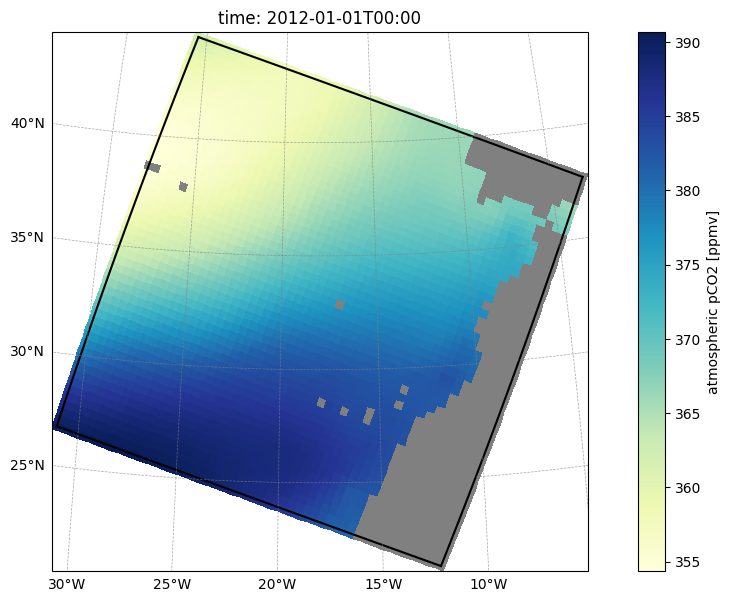

In [34]:
cesm_bgc_surface_forcing.plot("pco2_air", time=0)

[########################################] | 100% Completed | 101.26 ms


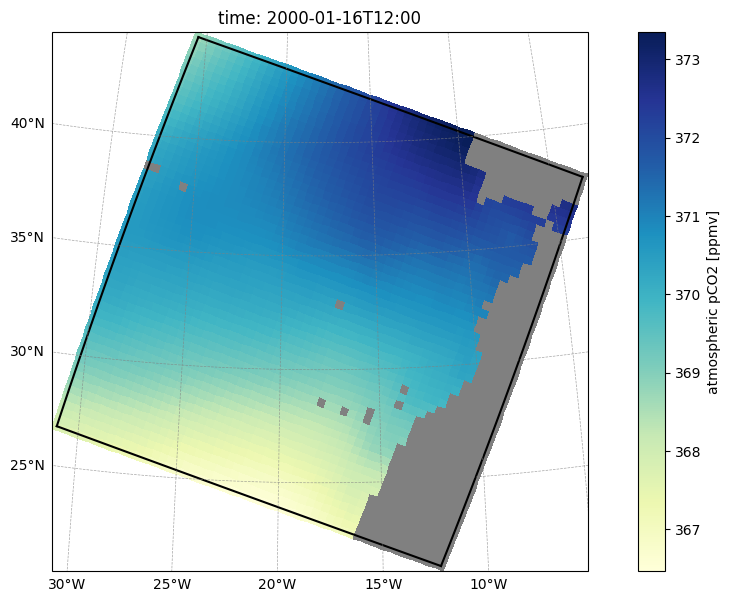

In [35]:
unified_bgc_surface_forcing.plot("pco2_air", time=0)

[########################################] | 100% Completed | 310.02 ms


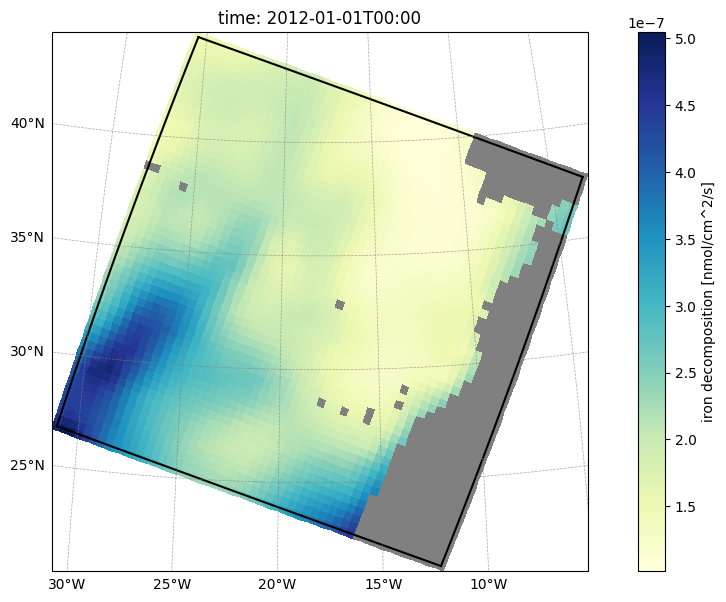

In [36]:
cesm_bgc_surface_forcing.plot("iron", time=0)

[########################################] | 100% Completed | 101.18 ms


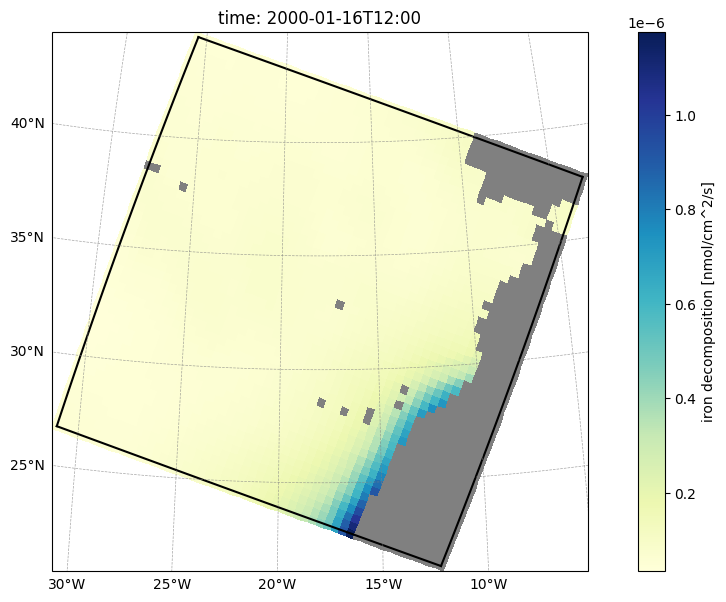

In [37]:
unified_bgc_surface_forcing.plot("iron", time=0)

[########################################] | 100% Completed | 302.69 ms


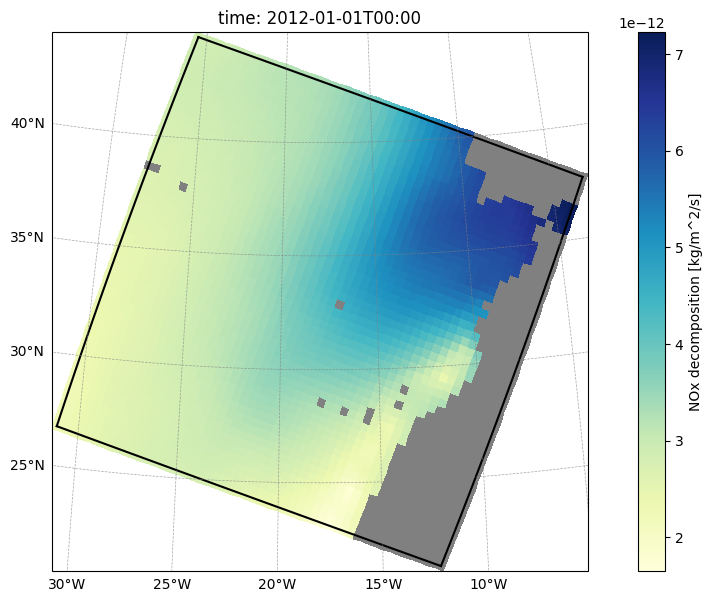

In [38]:
cesm_bgc_surface_forcing.plot("nox", time=0)

[########################################] | 100% Completed | 101.41 ms


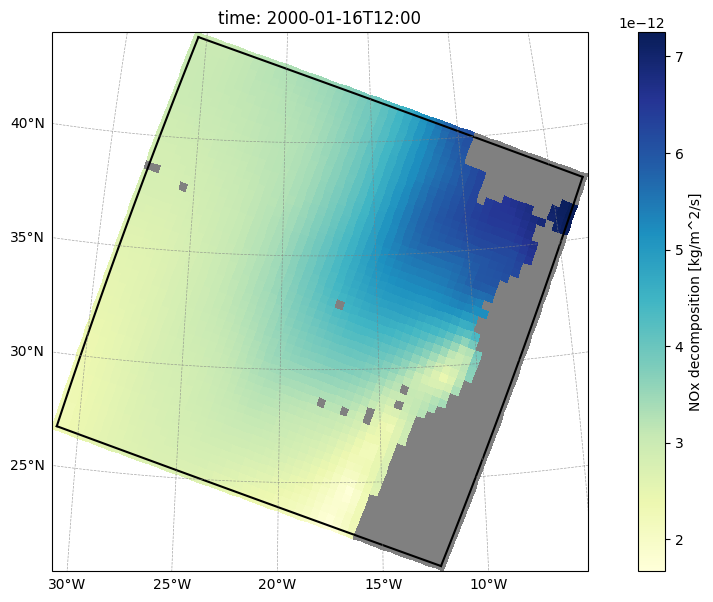

In [39]:
unified_bgc_surface_forcing.plot("nox", time=0)

## Saving as NetCDF or YAML file
Once we have decided which of the surface forcing versions we actually want to use, we can save the dataset as a NetCDF file.

We need to specify the desired target path.

In [40]:
filepath = "/pscratch/sd/n/nloose/forcing/my_bgc_surface_forcing.nc"

In [41]:
%time cesm_bgc_surface_forcing.save(filepath)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_bgc_surface_forcing_2012.nc


[########################################] | 100% Completed | 504.63 ms
CPU times: user 99.3 ms, sys: 56.1 ms, total: 155 ms
Wall time: 552 ms


[PosixPath('/pscratch/sd/n/nloose/forcing/my_bgc_surface_forcing_2012.nc')]

Alternatively, we can tell `ROMS-Tools` to group the surface forcing into multiple files ordered by months.

In [42]:
filepath = "/pscratch/sd/n/nloose/forcing/my_surface_forcing.nc"

In [43]:
%time surface_forcing.save(filepath, group=True)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201201.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201202.nc


[########################################] | 100% Completed | 64.96 s
[########################################] | 100% Completed | 16.24 s
CPU times: user 1h 22min 45s, sys: 33.8 s, total: 1h 23min 19s
Wall time: 1min 37s


[PosixPath('/pscratch/sd/n/nloose/forcing/my_surface_forcing_201201.nc'),
 PosixPath('/pscratch/sd/n/nloose/forcing/my_surface_forcing_201202.nc')]

From the file paths printed to the screen, you will notice that the year and month information has been appended to the specified path.

<div class="alert alert-info">

Note

The way data is grouped depends on its temporal frequency. For datasets with a daily or higher frequency, the data is grouped by month. For datasets with lower temporal frequency (e.g., monthly data), the grouping is done by year.

</div>

We can also export the parameters of our `SurfaceForcing` object to a YAML file.

In [44]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_surface_forcing.yaml"

In [45]:
surface_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [46]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 2.6.3.dev56+g1d1bdf8
---
Grid:
  nx: 100
  ny: 100
  size_x: 2000
  size_y: 2000
  center_lon: -18
  center_lat: 33
  rot: -20
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
SurfaceForcing:
  start_time: '2012-01-15T00:00:00'
  end_time: '2012-02-05T00:00:00'
  source:
    name: ERA5
    path: gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3
    climatology: false
  type: physics
  correct_radiation: true
  wind_dropoff: false
  coarse_grid_mode: auto
  model_reference_date: '2000-01-01T00:00:00'
  bypass_validation: false



## Creating surface forcing from an existing YAML file

In [47]:
%time the_same_surface_forcing = SurfaceForcing.from_yaml(yaml_filepath, use_dask=True)

INFO - Data will be interpolated onto fine grid.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 3min 34s, sys: 10.4 s, total: 3min 44s
Wall time: 1min 51s


In [48]:
the_same_surface_forcing.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    2.6.3.dev56+g1d1bdf8
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics